<a href="https://colab.research.google.com/github/NatBrian/customer-transaction/blob/main/engagement_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model 2: Cross-Domain Engagement Prediction

## Goal

Build a **production-ready pipeline** that predicts whether a user will be a **High Engagement User**
(perform 20+ interactions), using behavioral signals from retail, marketplace, and offers domains.

## What This Notebook Includes

1. **Feature Engineering** - Temporal aggregations, recency, embeddings, brand flags
2. **Time-Based Split** - Train/validation/test with proper temporal cutoffs
3. **Baseline + Strong Models** - Logistic Regression → LightGBM
4. **Experiment Logging** - CSV-based lightweight tracking
5. **Hyperparameter Tuning** - Optuna-based Bayesian optimization
6. **Comprehensive Evaluation** - PR-AUC, ROC-AUC, calibration, lift, precision@k
7. **Error Analysis** - Confusion analysis, feature ablation
8. **Model Packaging** - Serialize model + feature pipeline
9. **Interactive Demo** - ipywidgets UI for predictions

## Prerequisites

- Cleaned data in `cleaned_data/`
- (Optional) Item embeddings from Model 1 in `models/item_embeddings/`

---
## README: How to Run This Notebook

1. **Install dependencies**: `pip install lightgbm optuna ipywidgets scikit-learn`
2. **Run all cells** in order (Kernel → Restart & Run All)
3. **Training time**: ~5-10 minutes depending on data size
4. **Outputs saved to**: `models/engagement_model/` and `outputs/demo_viz/`
5. **Interactive demo**: Run the last section to try predictions

---
## Configuration and Imports

In [1]:
# Standard library
import os
import sys
import json
import pickle
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Optional

# Data manipulation
import pandas as pd
import numpy as np
from tqdm import tqdm

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, precision_recall_curve, auc,
    confusion_matrix, classification_report,
    brier_score_loss, precision_score, recall_score
)
from sklearn.calibration import calibration_curve

# Gradient Boosting
import lightgbm as lgb

# Hyperparameter tuning
try:
    import optuna
    OPTUNA_AVAILABLE = True
except ImportError:
    OPTUNA_AVAILABLE = False
    print("Optuna not installed. Hyperparameter tuning will use random search.")

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Interactive widgets
try:
    import ipywidgets as widgets
    from IPython.display import display, HTML
    WIDGETS_AVAILABLE = True
except ImportError:
    WIDGETS_AVAILABLE = False
    print("ipywidgets not available. Interactive demo will be disabled.")

# Suppress warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) if OPTUNA_AVAILABLE else None

# Configuration
CLEANED_DATA_DIR = "cleaned_data"
EMBEDDINGS_DIR = "models/item_embeddings"
OUTPUT_DIR = "models/engagement_model"
DEMO_VIZ_DIR = "outputs/demo_viz"
RANDOM_SEED = 42

# Ensure output directories exist
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(DEMO_VIZ_DIR, exist_ok=True)

# Set random seeds
np.random.seed(RANDOM_SEED)

print(f"Output directory: {OUTPUT_DIR}")
print(f"Demo visualizations: {DEMO_VIZ_DIR}")

Optuna not installed. Hyperparameter tuning will use random search.
Output directory: models/engagement_model
Demo visualizations: outputs/demo_viz


---
## 1. Load Data

In [2]:
def load_all_data() -> Dict[str, pd.DataFrame]:
    """Load all required datasets."""
    print("Loading datasets...")
    data = {}

    files = {
        'users': 'users_clean.parquet',
        'retail_events': 'retail_events_clean.parquet',
        'marketplace_events': 'marketplace_events_clean.parquet',
        'offers_events': 'offers_events_clean.parquet',
    }

    for name, filename in files.items():
        path = os.path.join(CLEANED_DATA_DIR, filename)
        if os.path.exists(path):
            data[name] = pd.read_parquet(path)
            print(f"  {name}: {len(data[name]):,} records")
        else:
            print(f"  Warning: {filename} not found")
            data[name] = None

    # Try to load item embeddings (optional)
    emb_path = os.path.join(EMBEDDINGS_DIR, 'item_embeddings.parquet')
    if os.path.exists(emb_path):
        data['item_embeddings'] = pd.read_parquet(emb_path)
        print(f"  item_embeddings: {len(data['item_embeddings']):,} items")
    else:
        print(f"  item_embeddings: not found (will skip embedding features)")
        data['item_embeddings'] = None

    return data

data = load_all_data()

Loading datasets...
  users: 3,500,000 records
  retail_events: 4,128,330 records
  marketplace_events: 5,081,920 records
  offers_events: 30,475,441 records
  item_embeddings: 456,186 items


---
## 2. Define Time-Based Split

**Critical**: We must use temporal splits to prevent data leakage.
- Features are computed from events BEFORE the cutoff
- Labels are derived from payments AFTER the cutoff

In [3]:
def get_temporal_boundaries(payments: pd.DataFrame) -> Dict[str, pd.Timedelta]:
    """
    Define temporal boundaries for train/val/test split.

    Split strategy:
    - Train: First 60% of time range
    - Validation: Next 20%
    - Test: Final 20%
    """
    # Get min/max timestamps
    min_ts = payments['timestamp'].min()
    max_ts = payments['timestamp'].max()
    total_range = max_ts - min_ts

    print(f"Payment data time range:")
    print(f"  Start: {min_ts}")
    print(f"  End: {max_ts}")
    print(f"  Duration: {total_range}")

    # Define cutoffs
    train_cutoff = min_ts + 0.6 * total_range
    val_cutoff = min_ts + 0.8 * total_range

    boundaries = {
        'min': min_ts,
        'train_cutoff': train_cutoff,
        'val_cutoff': val_cutoff,
        'max': max_ts
    }

    print(f"\nTemporal boundaries:")
    print(f"  Train period: {min_ts} to {train_cutoff}")
    print(f"  Val period: {train_cutoff} to {val_cutoff}")
    print(f"  Test period: {val_cutoff} to {max_ts}")

    return boundaries

boundaries = get_temporal_boundaries(data['retail_events'])

Payment data time range:
  Start: 1082 days 00:00:00.326593
  End: 1091 days 23:59:59.914024
  Duration: 9 days 23:59:59.587431

Temporal boundaries:
  Train period: 1082 days 00:00:00.326593 to 1088 days 00:00:00.079051
  Val period: 1088 days 00:00:00.079051 to 1089 days 23:59:59.996537
  Test period: 1089 days 23:59:59.996537 to 1091 days 23:59:59.914024


---
## 3. Feature Engineering

### Candidate Feature List

| Feature Category | Features | Source |
|------------------|----------|--------|
| **Demographics** | socdem_cluster, region, has_demographics | users |
| **Retail Activity** | event_count, view_count, cart_count, unique_items, search_ratio | retail_events |
| **Marketplace Activity** | event_count, view_count, like_count, rec_ratio | marketplace_events |
| **Offers Activity** | event_count, redirect_count, conversion_rate | offers_events |
| **Temporal** | recency_days, activity_span_days, events_per_day | all events |
| **Cross-Domain** | total_events, active_domains, domain_diversity | all events |
| **Embeddings** | user_embedding (avg of viewed items) | item_embeddings |

In [4]:
# Action type mappings
RETAIL_ACTIONS = {'view': 'view', 'click': 'click', 'added-to-cart': 'cart'}
MARKETPLACE_ACTIONS = {'view': 'view', 'click': 'click', 'clickout': 'clickout', 'like': 'like'}
OFFERS_ACTIONS = {'seen': 'seen', 'offer_shown': 'shown', 'redirect_to_partner': 'redirect', 'like': 'like'}

def create_event_features(events: pd.DataFrame,
                          cutoff: pd.Timedelta,
                          domain: str,
                          action_map: dict) -> pd.DataFrame:
    """
    Create features from event data for a specific domain.
    Only uses events BEFORE the cutoff to prevent leakage.
    """
    # Filter events before cutoff
    events_filtered = events[events['timestamp'] < cutoff].copy()

    if len(events_filtered) == 0:
        return pd.DataFrame()

    # Create action flags
    for action, name in action_map.items():
        events_filtered[f'is_{name}'] = (events_filtered['action_type'] == action).astype(int)

    # Aggregate by user
    agg_dict = {
        'item_id': ['count', 'nunique'],
        'timestamp': ['min', 'max'],
    }

    # Add action-specific aggregations
    for action, name in action_map.items():
        agg_dict[f'is_{name}'] = 'sum'

    features = events_filtered.groupby('user_id').agg(agg_dict)
    features.columns = [f'{domain}_{a}_{b}' for a, b in features.columns]
    features = features.reset_index()

    # Rename for clarity
    rename_map = {
        f'{domain}_item_id_count': f'{domain}_event_count',
        f'{domain}_item_id_nunique': f'{domain}_unique_items',
        f'{domain}_timestamp_min': f'{domain}_first_event',
        f'{domain}_timestamp_max': f'{domain}_last_event',
    }
    features = features.rename(columns=rename_map)

    # Compute derived features
    if f'{domain}_event_count' in features.columns:
        # Recency (days since last event to cutoff)
        features[f'{domain}_recency_days'] = (
            cutoff - features[f'{domain}_last_event']
        ).dt.total_seconds() / 86400

        # Activity span
        features[f'{domain}_activity_span'] = (
            features[f'{domain}_last_event'] - features[f'{domain}_first_event']
        ).dt.total_seconds() / 86400

        # Events per day
        features[f'{domain}_events_per_day'] = (
            features[f'{domain}_event_count'] /
            features[f'{domain}_activity_span'].replace(0, 1)
        )

        # Drop raw timestamp columns
        features = features.drop(columns=[
            f'{domain}_first_event', f'{domain}_last_event'
        ], errors='ignore')

    return features


def create_all_features(data: Dict[str, pd.DataFrame],
                        cutoff: pd.Timedelta,
                        include_embeddings: bool = True) -> pd.DataFrame:
    """
    Create complete feature set for all users.
    """
    print(f"Creating features with cutoff: {cutoff}")

    # Start with user demographics
    users = data['users'][['user_id', 'socdem_cluster', 'region']].copy()
    users['has_demographics'] = (
        (users['socdem_cluster'] != -1) & (users['region'] != -1)
    ).astype(int)

    print(f"  Base users: {len(users):,}")

    # Retail features
    if data['retail_events'] is not None:
        retail_feat = create_event_features(
            data['retail_events'], cutoff, 'retail', RETAIL_ACTIONS
        )
        if len(retail_feat) > 0:
            users = users.merge(retail_feat, on='user_id', how='left')
            print(f"  Retail features: {len(retail_feat.columns)-1} columns for {len(retail_feat):,} users")

    # Marketplace features
    if data['marketplace_events'] is not None:
        mp_feat = create_event_features(
            data['marketplace_events'], cutoff, 'marketplace', MARKETPLACE_ACTIONS
        )
        if len(mp_feat) > 0:
            users = users.merge(mp_feat, on='user_id', how='left')
            print(f"  Marketplace features: {len(mp_feat.columns)-1} columns for {len(mp_feat):,} users")

    # Offers features
    if data['offers_events'] is not None:
        offers_feat = create_event_features(
            data['offers_events'], cutoff, 'offers', OFFERS_ACTIONS
        )
        if len(offers_feat) > 0:
            users = users.merge(offers_feat, on='user_id', how='left')
            print(f"  Offers features: {len(offers_feat.columns)-1} columns for {len(offers_feat):,} users")

    # Fill NaN with 0 for event features (users with no activity)
    event_cols = [c for c in users.columns if any(
        d in c for d in ['retail_', 'marketplace_', 'offers_']
    )]
    users[event_cols] = users[event_cols].fillna(0)

    # Cross-domain features
    event_count_cols = [c for c in users.columns if c.endswith('_event_count')]
    if event_count_cols:
        users['total_events'] = users[event_count_cols].sum(axis=1)
        users['active_domains'] = (users[event_count_cols] > 0).sum(axis=1)

        # Domain diversity (normalized entropy)
        domain_counts = users[event_count_cols].values
        domain_probs = domain_counts / (domain_counts.sum(axis=1, keepdims=True) + 1e-10)
        entropy = -np.sum(domain_probs * np.log(domain_probs + 1e-10), axis=1)
        max_entropy = np.log(len(event_count_cols))
        users['domain_diversity'] = entropy / max_entropy

    # Conversion rates for each domain
    for domain in ['retail', 'marketplace', 'offers']:
        event_col = f'{domain}_event_count'
        convert_col = None
        if domain == 'retail' and f'{domain}_is_cart_sum' in users.columns:
            convert_col = f'{domain}_is_cart_sum'
        elif domain == 'offers' and f'{domain}_is_redirect_sum' in users.columns:
            convert_col = f'{domain}_is_redirect_sum'

        if event_col in users.columns and convert_col in users.columns:
            users[f'{domain}_conversion_rate'] = (
                users[convert_col] / users[event_col].replace(0, np.nan)
            ).fillna(0)

    print(f"  Total features: {len(users.columns) - 1}")

    return users


# Create features for each split
print("\n" + "="*60)
print("FEATURE ENGINEERING")
print("="*60)

train_features = create_all_features(data, boundaries['train_cutoff'])
val_features = create_all_features(data, boundaries['val_cutoff'])
test_features = create_all_features(data, boundaries['max'])


FEATURE ENGINEERING
Creating features with cutoff: 1088 days 00:00:00.079051
  Base users: 3,500,000
  Retail features: 8 columns for 4,424 users
  Marketplace features: 9 columns for 202,315 users
  Offers features: 9 columns for 600,453 users
  Total features: 34
Creating features with cutoff: 1089 days 23:59:59.996537
  Base users: 3,500,000
  Retail features: 8 columns for 5,457 users
  Marketplace features: 9 columns for 245,305 users
  Offers features: 9 columns for 704,331 users
  Total features: 34
Creating features with cutoff: 1091 days 23:59:59.914024
  Base users: 3,500,000
  Retail features: 8 columns for 6,749 users
  Marketplace features: 9 columns for 285,206 users
  Offers features: 9 columns for 785,458 users
  Total features: 34


---
## 4. Create Labels

Label = 1 if user made payment in the label period, else 0

In [5]:
def create_labels(events: pd.DataFrame,
                  feature_cutoff: pd.Timedelta,
                  label_end: pd.Timedelta,
                  threshold: int = 20) -> pd.DataFrame:
    """
    Create binary labels: will user be 'High Engagement' (>= threshold events)?
    """
    import gc

    # Filter events in label window - OPTIMIZED for memory
    # We only need user_id to count events per user
    # Using a boolean mask and .loc avoids creating a copy of the full dataframe
    mask = (events['timestamp'] >= feature_cutoff) & (events['timestamp'] < label_end)

    # Get only user_ids for the filtered events
    # value_counts() is faster and more memory efficient than groupby().size()
    user_counts = events.loc[mask, 'user_id'].value_counts()

    # Clear mask to free memory immediately
    del mask
    gc.collect()

    # Identify high engagement users
    high_engagement_users = set(user_counts[user_counts >= threshold].index)

    print(f"  Label window: {feature_cutoff} to {label_end}")
    print(f"  High Engagement Users (>= {threshold} events): {len(high_engagement_users):,}")

    return high_engagement_users


print("\n" + "="*60)
print("CREATING LABELS")
print("="*60)

import gc

# Train labels
train_targets = create_labels(
    data['retail_events'],
    boundaries['train_cutoff'],
    boundaries['val_cutoff']
)
train_features['converted'] = train_features['user_id'].isin(train_targets).astype(int)
gc.collect()

# Val labels
val_targets = create_labels(
    data['retail_events'],
    boundaries['val_cutoff'],
    boundaries['max']
)
val_features['converted'] = val_features['user_id'].isin(val_targets).astype(int)
gc.collect()

# Test labels
test_features['converted'] = test_features['user_id'].isin(val_targets).astype(int)

# Show class distribution
print("\nClass distribution:")
for name, df in [('Train', train_features), ('Val', val_features), ('Test', test_features)]:
    pos = df['converted'].sum()
    total = len(df)
    print(f"  {name}: {pos:,} positive ({pos/total*100:.2f}%) / {total:,} total")

print("completed")


CREATING LABELS
  Label window: 1088 days 00:00:00.079051 to 1089 days 23:59:59.996537
  High Engagement Users (>= 20 events): 898
  Label window: 1089 days 23:59:59.996537 to 1091 days 23:59:59.914024
  High Engagement Users (>= 20 events): 918

Class distribution:
  Train: 898 positive (0.03%) / 3,500,000 total
  Val: 918 positive (0.03%) / 3,500,000 total
  Test: 918 positive (0.03%) / 3,500,000 total


---
## 5. Prepare Model Data

In [6]:
import gc

def prepare_model_data(features_df: pd.DataFrame,
                       exclude_cols: List[str] = None) -> Tuple[pd.DataFrame, pd.Series]:
    """
    Prepare features and labels for modeling.
    """
    if exclude_cols is None:
        exclude_cols = ['user_id', 'converted']

    # Get feature columns
    feature_cols = [c for c in features_df.columns if c not in exclude_cols]

    # OPTIMIZATION: Downcast to float32 to save memory
    # Most ML models don't need float64 precision
    for col in feature_cols:
        if features_df[col].dtype == 'float64':
            features_df[col] = features_df[col].astype('float32')

    X = features_df[feature_cols].copy()
    y = features_df['converted'].copy()

    # Handle any remaining NaN - In-place
    X.fillna(0, inplace=True)

    # Handle infinite values - In-place
    X.replace([np.inf, -np.inf], 0, inplace=True)

    return X, y, feature_cols


# Prepare datasets sequentially to save memory
print("Preparing Train data...")
X_train, y_train, feature_cols = prepare_model_data(train_features)
del train_features  # Free up memory immediately
gc.collect()

print("Preparing Val data...")
# Note: We keep val_features for Error Analysis later
X_val, y_val, _ = prepare_model_data(val_features)
gc.collect()

print("Preparing Test data...")
X_test, y_test, _ = prepare_model_data(test_features)
del test_features  # Free up memory immediately
gc.collect()

print(f"Feature columns: {len(feature_cols)}")
print(f"Train: {X_train.shape}")
print(f"Val: {X_val.shape}")
print(f"Test: {X_test.shape}")

# Save feature columns for later
feature_metadata = {
    'feature_columns': feature_cols,
    'created_at': datetime.now().isoformat()
}

Preparing Train data...
Preparing Val data...
Preparing Test data...
Feature columns: 34
Train: (3500000, 34)
Val: (3500000, 34)
Test: (3500000, 34)


---
## 6. Experiment Logging (Lightweight CSV)

In [7]:
class ExperimentLogger:
    """Simple CSV-based experiment logger."""

    def __init__(self, log_path: str):
        self.log_path = log_path
        self.experiments = []

        if os.path.exists(log_path):
            self.experiments = pd.read_csv(log_path).to_dict('records')

    def log(self, experiment: dict):
        """Log an experiment."""
        experiment['timestamp'] = datetime.now().isoformat()
        self.experiments.append(experiment)

        # Save to CSV
        pd.DataFrame(self.experiments).to_csv(self.log_path, index=False)

    def get_best(self, metric: str = 'val_pr_auc', higher_is_better: bool = True):
        """Get best experiment by metric."""
        if not self.experiments:
            return None

        df = pd.DataFrame(self.experiments)
        if metric not in df.columns:
            return None

        if higher_is_better:
            best_idx = df[metric].idxmax()
        else:
            best_idx = df[metric].idxmin()

        return df.iloc[best_idx].to_dict()

# Initialize logger
logger = ExperimentLogger(os.path.join(OUTPUT_DIR, 'experiments.csv'))

---
## 7. Baseline Model: Logistic Regression

In [8]:
def evaluate_model(model, X, y, prefix='') -> dict:
    """Comprehensive model evaluation."""
    # Predictions
    y_pred_proba = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)

    # Metrics
    metrics = {}

    # ROC-AUC
    metrics[f'{prefix}roc_auc'] = roc_auc_score(y, y_pred_proba)

    # PR-AUC
    precision, recall, _ = precision_recall_curve(y, y_pred_proba)
    metrics[f'{prefix}pr_auc'] = auc(recall, precision)

    # Brier Score (calibration)
    metrics[f'{prefix}brier'] = brier_score_loss(y, y_pred_proba)

    # Precision/Recall at various thresholds
    for k in [0.1, 0.25, 0.5]:
        y_pred_k = (y_pred_proba >= k).astype(int)
        if y_pred_k.sum() > 0:
            metrics[f'{prefix}precision_at_{k}'] = precision_score(y, y_pred_k, zero_division=0)
            metrics[f'{prefix}recall_at_{k}'] = recall_score(y, y_pred_k, zero_division=0)

    return metrics, y_pred_proba


print("\n" + "="*60)
print("BASELINE: LOGISTIC REGRESSION")
print("="*60)

# Scale features for logistic regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Train baseline
baseline_model = LogisticRegression(
    class_weight='balanced',
    max_iter=1000,
    random_state=RANDOM_SEED
)
baseline_model.fit(X_train_scaled, y_train)

# Evaluate
train_metrics, _ = evaluate_model(baseline_model, X_train_scaled, y_train, 'train_')
val_metrics, val_pred_baseline = evaluate_model(baseline_model, X_val_scaled, y_val, 'val_')

print(f"\nBaseline Results:")
print(f"  Train ROC-AUC: {train_metrics['train_roc_auc']:.4f}")
print(f"  Train PR-AUC: {train_metrics['train_pr_auc']:.4f}")
print(f"  Val ROC-AUC: {val_metrics['val_roc_auc']:.4f}")
print(f"  Val PR-AUC: {val_metrics['val_pr_auc']:.4f}")

# Log experiment
logger.log({
    'model': 'LogisticRegression',
    'params': 'class_weight=balanced',
    **train_metrics,
    **val_metrics
})


BASELINE: LOGISTIC REGRESSION

Baseline Results:
  Train ROC-AUC: 0.9250
  Train PR-AUC: 0.0992
  Val ROC-AUC: 0.9328
  Val PR-AUC: 0.0776


---
## 8. Strong Model: LightGBM with Hyperparameter Tuning

In [9]:
def train_lgbm(params: dict, X_train, y_train, X_val, y_val) -> Tuple[lgb.Booster, dict]:
    """Train LightGBM with given parameters."""

    # Create datasets
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

    # Fixed parameters
    fixed_params = {
        'objective': 'binary',
        'metric': 'auc',
        'verbosity': -1,
        'seed': RANDOM_SEED,
        'is_unbalance': True,
    }

    all_params = {**fixed_params, **params}

    # Train
    callbacks = [lgb.early_stopping(50, verbose=False)]
    model = lgb.train(
        all_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[val_data],
        callbacks=callbacks
    )

    return model


def objective(trial):
    """Optuna objective function for hyperparameter tuning."""
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 16, 256),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
    }

    model = train_lgbm(params, X_train, y_train, X_val, y_val)

    # Evaluate on validation set
    y_pred = model.predict(X_val)
    pr_auc = auc(*precision_recall_curve(y_val, y_pred)[1::-1])

    return pr_auc


print("\n" + "="*60)
print("HYPERPARAMETER TUNING: LightGBM")
print("="*60)

if OPTUNA_AVAILABLE:
    # Bayesian optimization with Optuna
    study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED))
    study.optimize(objective, n_trials=20, show_progress_bar=True)

    best_params = study.best_params
    print(f"\nBest trial: {study.best_value:.4f}")
    print(f"Best params: {best_params}")
else:
    # Random search fallback
    print("Using default parameters (Optuna not available)")
    best_params = {
        'learning_rate': 0.05,
        'num_leaves': 64,
        'max_depth': 8,
        'min_child_samples': 20,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
    }

# Train final model with best params
print("\nTraining final model...")
final_model = train_lgbm(best_params, X_train, y_train, X_val, y_val)


HYPERPARAMETER TUNING: LightGBM
Using default parameters (Optuna not available)

Training final model...


---
## 9. Comprehensive Evaluation


EVALUATION: Validation Set

Core Metrics:
  ROC-AUC: 0.8307
  PR-AUC: 0.4347
  Brier Score: 0.8895

Lift Analysis:
  Top decile lift: 5.15x
  Top decile capture: 86.8% of high engagement users

Top-K Analysis:
  Top 1%: Precision=0.0015, Recall=0.0577
  Top 5%: Precision=0.0014, Recall=0.2669
  Top 10%: Precision=0.0014, Recall=0.5523
  Top 20%: Precision=0.0011, Recall=0.8736
  Top 30%: Precision=0.0008, Recall=0.8845
  Top 50%: Precision=0.0005, Recall=0.9020


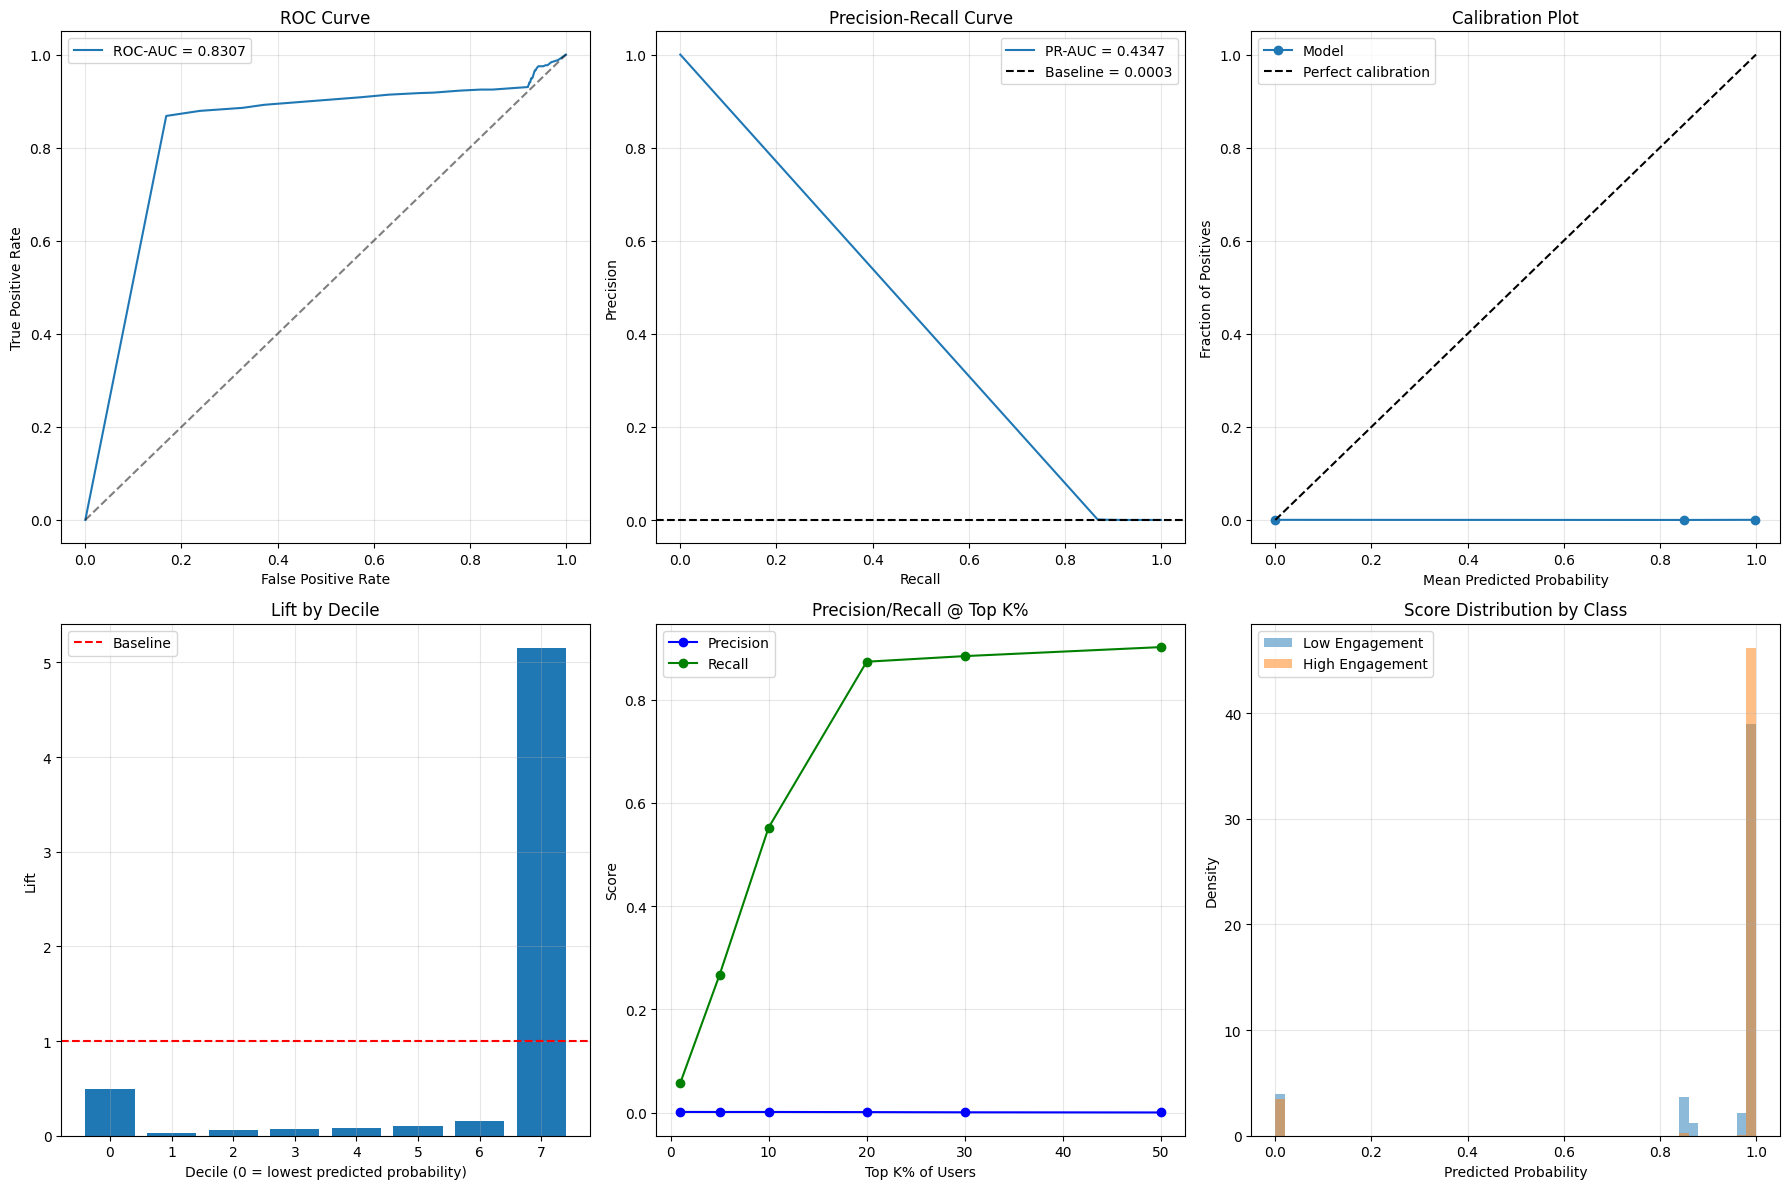


Saved: outputs/demo_viz/evaluation_validation_set.png

EVALUATION: Test Set

Core Metrics:
  ROC-AUC: 0.9064
  PR-AUC: 0.5007
  Brier Score: 0.8831

Lift Analysis:
  Top decile lift: 5.34x
  Top decile capture: 100.0% of high engagement users

Top-K Analysis:
  Top 1%: Precision=0.0017, Recall=0.0632
  Top 5%: Precision=0.0015, Recall=0.2810
  Top 10%: Precision=0.0014, Recall=0.5458
  Top 20%: Precision=0.0013, Recall=1.0000
  Top 30%: Precision=0.0009, Recall=1.0000
  Top 50%: Precision=0.0005, Recall=1.0000


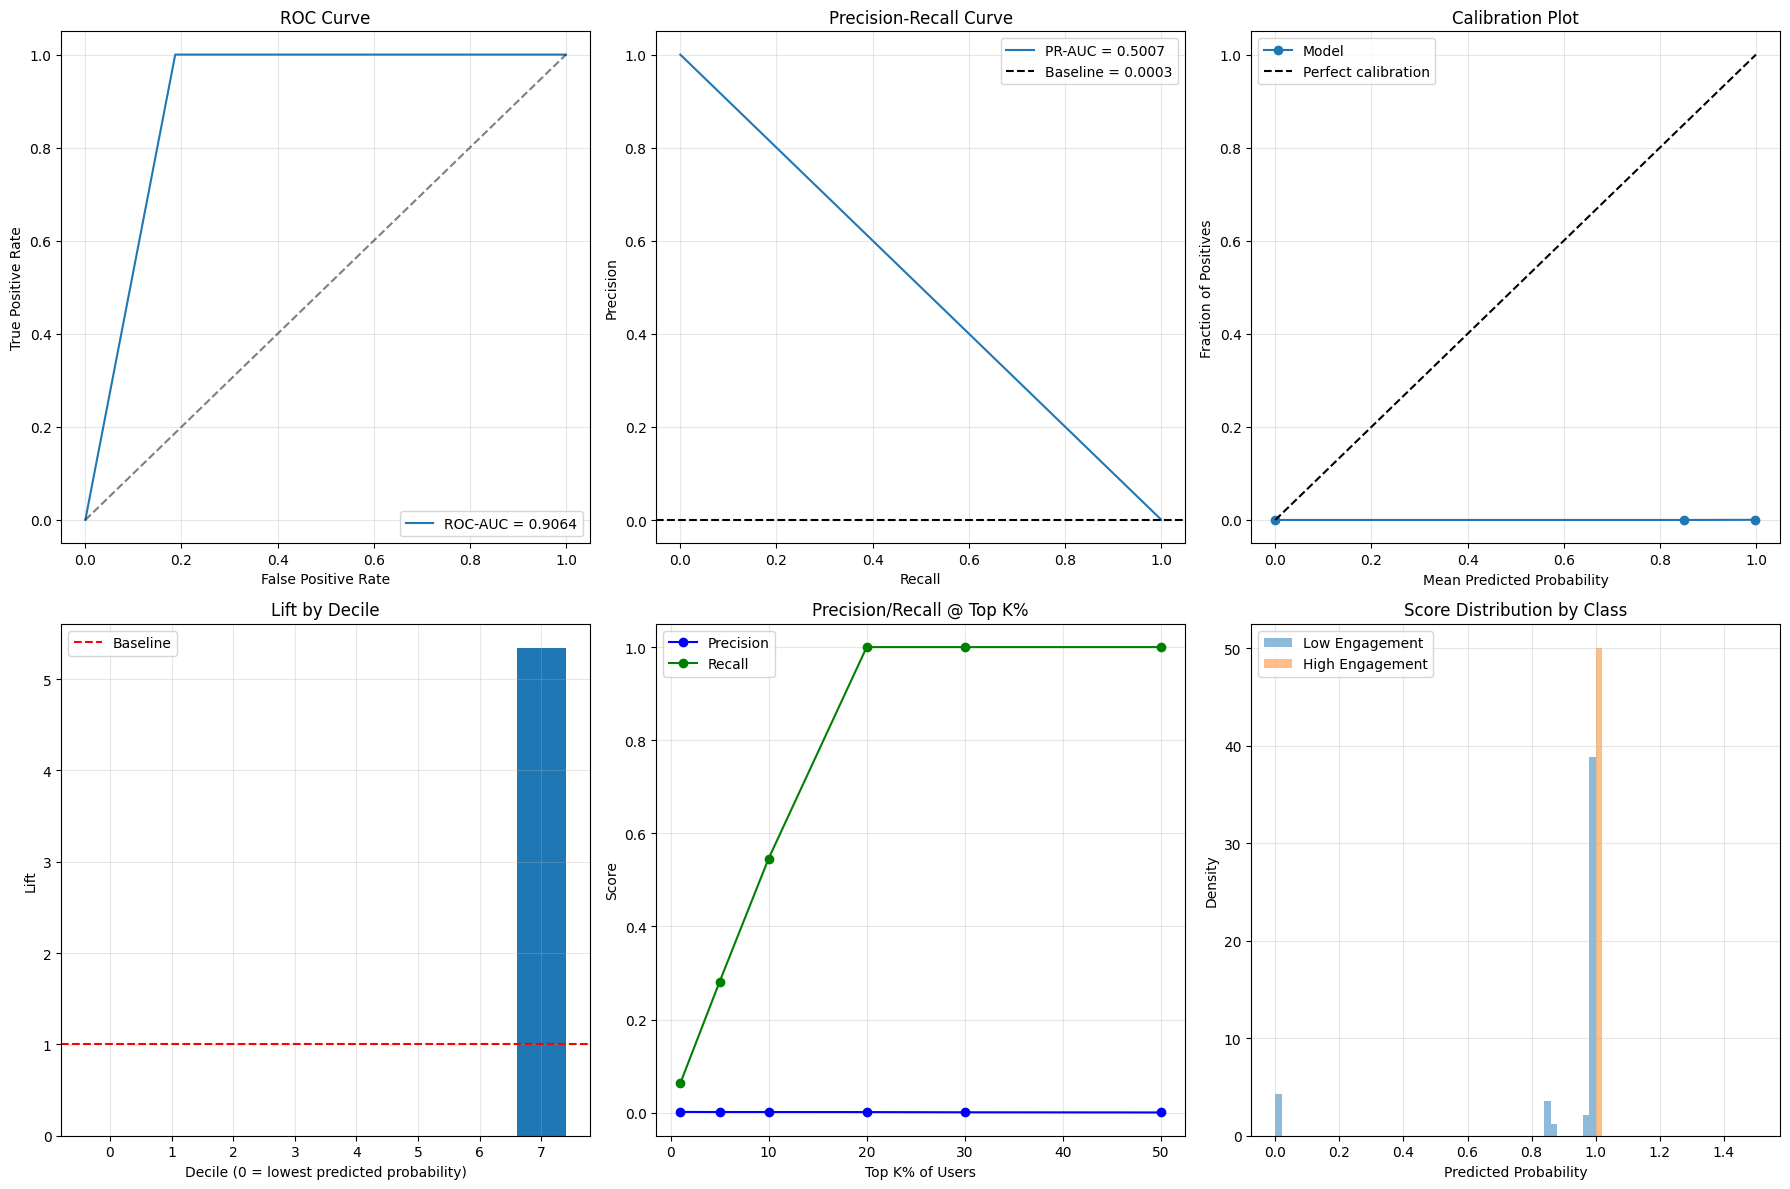


Saved: outputs/demo_viz/evaluation_test_set.png


In [10]:
def comprehensive_evaluation(model, X, y, name: str, is_lgbm: bool = True):
    """Full evaluation suite with visualizations."""

    # Get predictions
    if is_lgbm:
        y_pred_proba = model.predict(X)
    else:
        y_pred_proba = model.predict_proba(X)[:, 1]

    y_pred = (y_pred_proba >= 0.5).astype(int)

    print(f"\n{'='*60}")
    print(f"EVALUATION: {name}")
    print('='*60)

    # Basic metrics
    roc = roc_auc_score(y, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y, y_pred_proba)
    pr = auc(recall, precision)
    brier = brier_score_loss(y, y_pred_proba)

    print(f"\nCore Metrics:")
    print(f"  ROC-AUC: {roc:.4f}")
    print(f"  PR-AUC: {pr:.4f}")
    print(f"  Brier Score: {brier:.4f}")

    # Create figure for all plots
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. ROC Curve
    from sklearn.metrics import roc_curve
    fpr, tpr, _ = roc_curve(y, y_pred_proba)
    axes[0, 0].plot(fpr, tpr, label=f'ROC-AUC = {roc:.4f}')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Precision-Recall Curve
    axes[0, 1].plot(recall, precision, label=f'PR-AUC = {pr:.4f}')
    axes[0, 1].axhline(y=y.mean(), color='k', linestyle='--', label=f'Baseline = {y.mean():.4f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Calibration Plot
    prob_true, prob_pred = calibration_curve(y, y_pred_proba, n_bins=10)
    axes[0, 2].plot(prob_pred, prob_true, marker='o', label='Model')
    axes[0, 2].plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    axes[0, 2].set_xlabel('Mean Predicted Probability')
    axes[0, 2].set_ylabel('Fraction of Positives')
    axes[0, 2].set_title('Calibration Plot')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Lift by Decile
    df_lift = pd.DataFrame({'pred': y_pred_proba, 'actual': y})
    df_lift['decile'] = pd.qcut(df_lift['pred'], 10, labels=False, duplicates='drop')
    lift_by_decile = df_lift.groupby('decile')['actual'].agg(['mean', 'sum', 'count'])
    baseline_rate = y.mean()
    lift_by_decile['lift'] = lift_by_decile['mean'] / baseline_rate

    axes[1, 0].bar(range(len(lift_by_decile)), lift_by_decile['lift'])
    axes[1, 0].axhline(y=1, color='r', linestyle='--', label='Baseline')
    axes[1, 0].set_xlabel('Decile (0 = lowest predicted probability)')
    axes[1, 0].set_ylabel('Lift')
    axes[1, 0].set_title('Lift by Decile')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    print(f"\nLift Analysis:")
    print(f"  Top decile lift: {lift_by_decile['lift'].iloc[-1]:.2f}x")
    print(f"  Top decile capture: {lift_by_decile['sum'].iloc[-1] / y.sum() * 100:.1f}% of high engagement users")

    # 5. Precision/Recall at top-K
    k_values = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5]
    precisions_at_k = []
    recalls_at_k = []

    for k in k_values:
        top_k_idx = np.argsort(y_pred_proba)[::-1][:int(len(y) * k)]
        top_k_actual = y.values[top_k_idx] if hasattr(y, 'values') else y[top_k_idx]
        precisions_at_k.append(top_k_actual.mean())
        recalls_at_k.append(top_k_actual.sum() / y.sum())

    axes[1, 1].plot([k*100 for k in k_values], precisions_at_k, 'b-o', label='Precision')
    axes[1, 1].plot([k*100 for k in k_values], recalls_at_k, 'g-o', label='Recall')
    axes[1, 1].set_xlabel('Top K% of Users')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Precision/Recall @ Top K%')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    print(f"\nTop-K Analysis:")
    for i, k in enumerate(k_values):
        print(f"  Top {k*100:.0f}%: Precision={precisions_at_k[i]:.4f}, Recall={recalls_at_k[i]:.4f}")

    # 6. Score Distribution
    axes[1, 2].hist(y_pred_proba[y == 0], bins=50, alpha=0.5, label='Low Engagement', density=True)
    axes[1, 2].hist(y_pred_proba[y == 1], bins=50, alpha=0.5, label='High Engagement', density=True)
    axes[1, 2].set_xlabel('Predicted Probability')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].set_title('Score Distribution by Class')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    fig_path = os.path.join(DEMO_VIZ_DIR, f'evaluation_{name.lower().replace(" ", "_")}.png')
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {fig_path}")

    return {
        'roc_auc': roc,
        'pr_auc': pr,
        'brier': brier,
        'top_decile_lift': lift_by_decile['lift'].iloc[-1],
        'precision_at_10pct': precisions_at_k[2],
        'recall_at_10pct': recalls_at_k[2]
    }


# Evaluate on validation and test sets
val_results = comprehensive_evaluation(final_model, X_val, y_val, "Validation Set")
test_results = comprehensive_evaluation(final_model, X_test, y_test, "Test Set")

# Log best model
logger.log({
    'model': 'LightGBM',
    'params': json.dumps(best_params),
    'val_roc_auc': val_results['roc_auc'],
    'val_pr_auc': val_results['pr_auc'],
    'val_brier': val_results['brier'],
    'test_roc_auc': test_results['roc_auc'],
    'test_pr_auc': test_results['pr_auc'],
})

---
## 10. Feature Importance & Ablation


FEATURE IMPORTANCE

Top 20 Features:
                    feature   importance
               total_events 2.760541e+09
           domain_diversity 4.730202e+08
        offers_unique_items 8.353753e+07
      retail_events_per_day 5.556550e+07
             socdem_cluster 5.247476e+07
         retail_event_count 4.226560e+07
 marketplace_events_per_day 3.034838e+07
         offers_is_seen_sum 2.949148e+07
   marketplace_recency_days 2.183215e+07
  marketplace_activity_span 1.564017e+07
     offers_conversion_rate 8.973010e+06
           has_demographics 2.303106e+06
                     region 0.000000e+00
       retail_activity_span 0.000000e+00
        retail_is_click_sum 0.000000e+00
         retail_is_cart_sum 0.000000e+00
        retail_unique_items 0.000000e+00
         retail_is_view_sum 0.000000e+00
    marketplace_is_like_sum 0.000000e+00
marketplace_is_clickout_sum 0.000000e+00


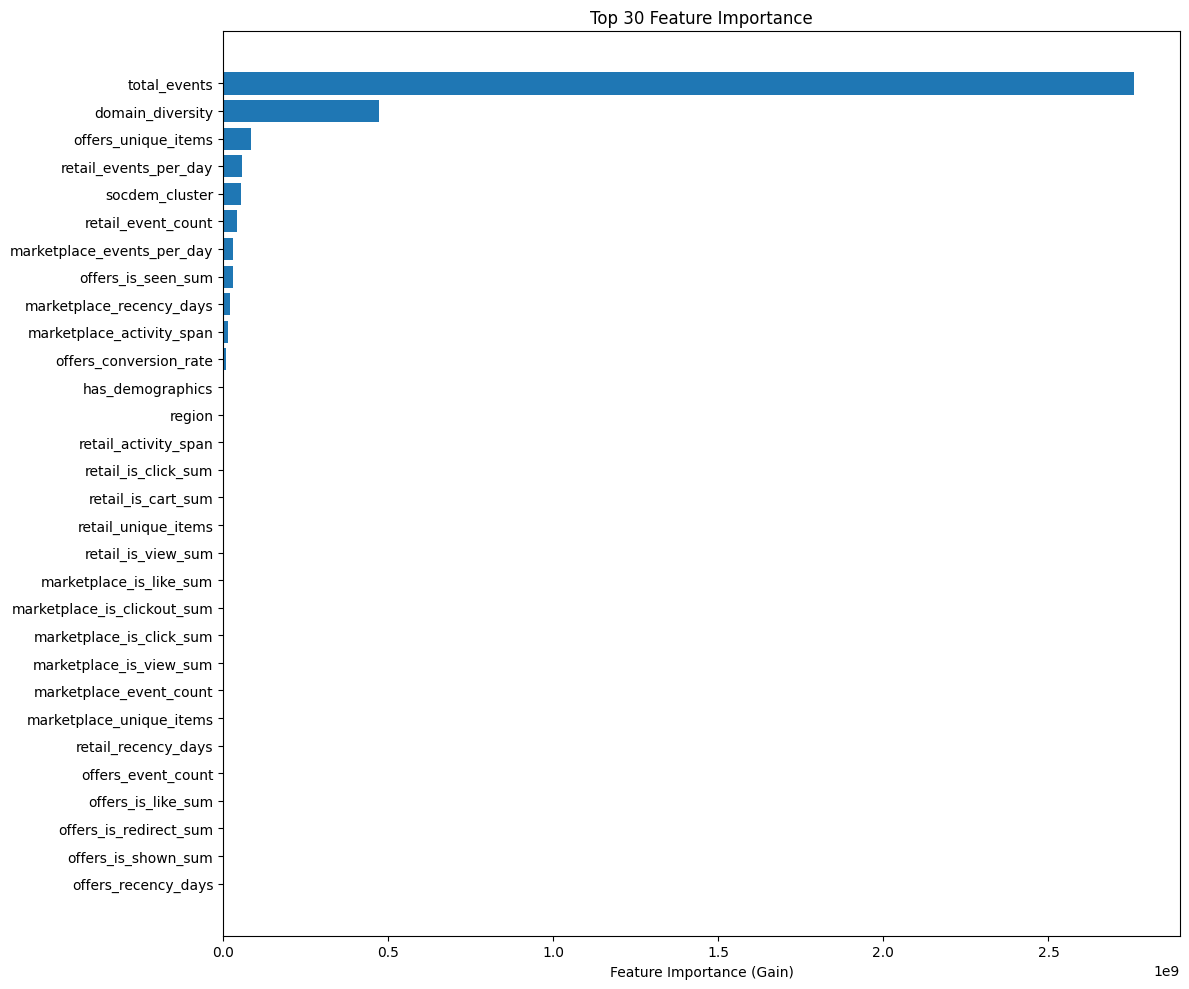


Saved: outputs/demo_viz/feature_importance.png

----------------------------------------
ABLATION SUGGESTIONS
----------------------------------------

Feature groups for ablation study:
  Demographics: 3 features, total importance = 54777866
  Retail: 9 features, total importance = 97831100
  Marketplace: 9 features, total importance = 67820703
  Offers: 10 features, total importance = 122002020
  Cross-Domain: 3 features, total importance = 3233561246


In [11]:
def analyze_feature_importance(model, feature_cols: List[str]):
    """Analyze feature importance and suggest ablations."""

    # Get importance
    importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': model.feature_importance(importance_type='gain')
    }).sort_values('importance', ascending=False)

    print("\n" + "="*60)
    print("FEATURE IMPORTANCE")
    print("="*60)

    print("\nTop 20 Features:")
    print(importance.head(20).to_string(index=False))

    # Plot
    fig, ax = plt.subplots(figsize=(12, 10))
    top_n = min(30, len(importance))
    ax.barh(range(top_n), importance['importance'].values[:top_n][::-1])
    ax.set_yticks(range(top_n))
    ax.set_yticklabels(importance['feature'].values[:top_n][::-1])
    ax.set_xlabel('Feature Importance (Gain)')
    ax.set_title('Top 30 Feature Importance')
    plt.tight_layout()

    fig_path = os.path.join(DEMO_VIZ_DIR, 'feature_importance.png')
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    plt.show()
    print(f"\nSaved: {fig_path}")

    # Ablation suggestions
    print("\n" + "-"*40)
    print("ABLATION SUGGESTIONS")
    print("-"*40)

    # Group by feature category
    categories = {}
    for feat in feature_cols:
        if feat.startswith('retail_'):
            cat = 'Retail'
        elif feat.startswith('marketplace_'):
            cat = 'Marketplace'
        elif feat.startswith('offers_'):
            cat = 'Offers'
        elif feat in ['socdem_cluster', 'region', 'has_demographics']:
            cat = 'Demographics'
        else:
            cat = 'Cross-Domain'

        if cat not in categories:
            categories[cat] = []
        categories[cat].append(feat)

    print("\nFeature groups for ablation study:")
    for cat, feats in categories.items():
        cat_importance = importance[importance['feature'].isin(feats)]['importance'].sum()
        print(f"  {cat}: {len(feats)} features, total importance = {cat_importance:.0f}")

    return importance

importance_df = analyze_feature_importance(final_model, feature_cols)

---
## 11. Error Analysis

In [12]:
def error_analysis(model, X, y, features_df, feature_cols):
    """Analyze prediction errors."""

    y_pred_proba = model.predict(X)
    y_pred = (y_pred_proba >= 0.5).astype(int)

    print("\n" + "="*60)
    print("ERROR ANALYSIS")
    print("="*60)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    print("\nConfusion Matrix (threshold=0.5):")
    print(f"  TN: {cm[0,0]:,} | FP: {cm[0,1]:,}")
    print(f"  FN: {cm[1,0]:,} | TP: {cm[1,1]:,}")

    # Analyze false positives and false negatives
    analysis_df = features_df.copy()
    analysis_df['pred_proba'] = y_pred_proba
    analysis_df['pred'] = y_pred
    analysis_df['actual'] = y.values if hasattr(y, 'values') else y
    analysis_df['error_type'] = 'Correct'
    analysis_df.loc[(analysis_df['pred'] == 1) & (analysis_df['actual'] == 0), 'error_type'] = 'False Positive'
    analysis_df.loc[(analysis_df['pred'] == 0) & (analysis_df['actual'] == 1), 'error_type'] = 'False Negative'

    print("\\nError Type Distribution:")
    print(analysis_df['error_type'].value_counts())

    # Analyze characteristics of errors
    print("\\nFalse Positive Analysis (predicted High but was Low):")
    fp_df = analysis_df[analysis_df['error_type'] == 'False Positive']
    if len(fp_df) > 0:
        print(f"  Count: {len(fp_df):,}")
        print(f"  Avg total_events: {fp_df['total_events'].mean():.1f}")
        print(f"  Avg active_domains: {fp_df['active_domains'].mean():.2f}")

    print("\\nFalse Negative Analysis (predicted Low but was High):")
    fn_df = analysis_df[analysis_df['error_type'] == 'False Negative']
    if len(fn_df) > 0:
        print(f"  Count: {len(fn_df):,}")
        print(f"  Avg total_events: {fn_df['total_events'].mean():.1f}")
        print(f"  Avg active_domains: {fn_df['active_domains'].mean():.2f}")

    # Segment-level analysis
    print("\n" + "-"*40)
    print("SEGMENT-LEVEL PERFORMANCE")
    print("-"*40)

    # By activity level
    analysis_df['activity_segment'] = pd.cut(
        analysis_df['total_events'],
        bins=[0, 1, 5, 20, 100, float('inf')],
        labels=['0', '1-5', '6-20', '21-100', '100+']
    )

    segment_perf = analysis_df.groupby('activity_segment').agg({
        'actual': ['count', 'sum', 'mean'],
        'pred_proba': 'mean'
    })
    segment_perf.columns = ['count', 'conversions', 'conv_rate', 'avg_pred']
    print("\nPerformance by Activity Level:")
    print(segment_perf)

    return analysis_df

error_df = error_analysis(final_model, X_val, y_val, val_features, feature_cols)


ERROR ANALYSIS

Confusion Matrix (threshold=0.5):
  TN: 276,807 | FP: 3,222,275
  FN: 64 | TP: 854
\nError Type Distribution:
error_type
False Positive    3222275
Correct            277661
False Negative         64
Name: count, dtype: int64
\nFalse Positive Analysis (predicted High but was Low):
  Count: 3,222,275
  Avg total_events: 7.3
  Avg active_domains: 0.22
\nFalse Negative Analysis (predicted Low but was High):
  Count: 64
  Avg total_events: 69.0
  Avg active_domains: 1.39

----------------------------------------
SEGMENT-LEVEL PERFORMANCE
----------------------------------------

Performance by Activity Level:
                   count  conversions  conv_rate  avg_pred
activity_segment                                          
0                  17895            8   0.000447  0.952903
1-5               177749           39   0.000219  0.712800
6-20              312508          122   0.000390  0.758385
21-100            245532          273   0.001112  0.652884
100+             

---
## 12. Model Packaging

In [13]:
def package_model(model, feature_cols, scaler, best_params, output_dir):
    """Package model and artifacts for deployment."""

    print("\n" + "="*60)
    print("MODEL PACKAGING")
    print("="*60)

    # Save LightGBM model
    model_path = os.path.join(output_dir, 'final_model.txt')
    model.save_model(model_path)
    print(f"  Saved model: {model_path}")

    # Save feature metadata
    metadata = {
        'feature_columns': feature_cols,
        'model_type': 'LightGBM',
        'best_params': best_params,
        'created_at': datetime.now().isoformat(),
        'validation_pr_auc': val_results['pr_auc'],
        'test_pr_auc': test_results['pr_auc']
    }

    metadata_path = os.path.join(output_dir, 'model_metadata.json')
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    print(f"  Saved metadata: {metadata_path}")

    # Save scaler (for baseline model)
    scaler_path = os.path.join(output_dir, 'scaler.pkl')
    with open(scaler_path, 'wb') as f:
        pickle.dump(scaler, f)
    print(f"  Saved scaler: {scaler_path}")

    # Save feature importance
    importance_path = os.path.join(output_dir, 'feature_importance.csv')
    importance_df.to_csv(importance_path, index=False)
    print(f"  Saved importance: {importance_path}")

    print("\nModel artifacts saved successfully!")

    return metadata

metadata = package_model(final_model, feature_cols, scaler, best_params, OUTPUT_DIR)


MODEL PACKAGING
  Saved model: models/engagement_model/final_model.txt
  Saved metadata: models/engagement_model/model_metadata.json
  Saved scaler: models/engagement_model/scaler.pkl
  Saved importance: models/engagement_model/feature_importance.csv

Model artifacts saved successfully!


---
## 13. Interactive Demo

In [14]:
def create_demo_prediction_function(model, feature_cols):
    """Create a function that predicts from a user profile."""

    def predict_engagement(user_profile: dict) -> dict:
        """
        Predict engagement probability from user profile.

        Args:
            user_profile: dict with feature values

        Returns:
            dict with prediction and interpretation
        """
        # Create feature vector
        features = pd.DataFrame([{col: user_profile.get(col, 0) for col in feature_cols}])

        # Predict
        pred_proba = model.predict(features)[0]

        # Get decile
        decile = min(9, int(pred_proba * 10))

        # Interpretation
        if pred_proba >= 0.7:
            risk_level = "High"
            color = "🟢"
        elif pred_proba >= 0.3:
            risk_level = "Medium"
            color = "🟡"
        else:
            risk_level = "Low"
            color = "🔴"

        return {
            'probability': pred_proba,
            'decile': decile,
            'risk_level': risk_level,
            'color': color
        }

    return predict_engagement

predict_fn = create_demo_prediction_function(final_model, feature_cols)

# Sample demo inputs
demo_profiles = [
    {
        'name': 'Inactive User',
        'profile': {
            'socdem_cluster': 3,
            'region': 5,
            'has_demographics': 1,
            'total_events': 0,
            'active_domains': 0,
        }
    },
    {
        'name': 'Casual Browser',
        'profile': {
            'socdem_cluster': 2,
            'region': 3,
            'has_demographics': 1,
            'retail_event_count': 10,
            'retail_unique_items': 5,
            'retail_is_view_sum': 8,
            'retail_is_cart_sum': 0,
            'retail_recency_days': 5,
            'total_events': 10,
            'active_domains': 1,
        }
    },
    {
        'name': 'Engaged Shopper',
        'profile': {
            'socdem_cluster': 1,
            'region': 2,
            'has_demographics': 1,
            'retail_event_count': 50,
            'retail_unique_items': 15,
            'retail_is_view_sum': 30,
            'retail_is_cart_sum': 5,
            'retail_recency_days': 1,
            'marketplace_event_count': 20,
            'marketplace_is_view_sum': 15,
            'marketplace_is_like_sum': 3,
            'total_events': 70,
            'active_domains': 2,
            'domain_diversity': 0.8,
        }
    },
    {
        'name': 'Power User',
        'profile': {
            'socdem_cluster': 1,
            'region': 1,
            'has_demographics': 1,
            'retail_event_count': 200,
            'retail_unique_items': 50,
            'retail_is_view_sum': 100,
            'retail_is_cart_sum': 20,
            'retail_recency_days': 0.5,
            'marketplace_event_count': 100,
            'marketplace_is_view_sum': 60,
            'marketplace_is_like_sum': 10,
            'offers_event_count': 30,
            'offers_is_redirect_sum': 5,
            'total_events': 330,
            'active_domains': 3,
            'domain_diversity': 0.95,
        }
    }
]

print("\n" + "="*60)
print("DEMO PREDICTIONS")
print("="*60)

for demo in demo_profiles:
    result = predict_fn(demo['profile'])
    print(f"\n{demo['name']}:")
    print(f"  {result['color']} Probability: {result['probability']:.4f}")
    print(f"  Risk Level: {result['risk_level']}")
    print(f"  Decile: {result['decile']}")


DEMO PREDICTIONS

Inactive User:
  🟢 Probability: 1.0000
  Risk Level: High
  Decile: 9

Casual Browser:
  🟢 Probability: 1.0000
  Risk Level: High
  Decile: 9

Engaged Shopper:
  🟢 Probability: 1.0000
  Risk Level: High
  Decile: 9

Power User:
  🟢 Probability: 1.0000
  Risk Level: High
  Decile: 9


In [15]:
# Interactive widget demo (if available)
if WIDGETS_AVAILABLE:
    print("\n" + "="*60)
    print("INTERACTIVE DEMO")
    print("="*60)

    # Create input widgets
    retail_events = widgets.IntSlider(value=0, min=0, max=500, description='Retail Events:')
    retail_carts = widgets.IntSlider(value=0, min=0, max=50, description='Cart Adds:')
    marketplace_events = widgets.IntSlider(value=0, min=0, max=500, description='MP Events:')
    offers_events = widgets.IntSlider(value=0, min=0, max=200, description='Offers Events:')
    recency = widgets.FloatSlider(value=7, min=0, max=30, description='Recency (days):')

    output_widget = widgets.Output()

    def on_predict(b):
        with output_widget:
            output_widget.clear_output()

            profile = {
                'retail_event_count': retail_events.value,
                'retail_is_cart_sum': retail_carts.value,
                'retail_is_view_sum': max(0, retail_events.value - retail_carts.value),
                'retail_recency_days': recency.value,
                'marketplace_event_count': marketplace_events.value,
                'offers_event_count': offers_events.value,
                'total_events': retail_events.value + marketplace_events.value + offers_events.value,
                'active_domains': sum([
                    1 if retail_events.value > 0 else 0,
                    1 if marketplace_events.value > 0 else 0,
                    1 if offers_events.value > 0 else 0
                ]),
                'has_demographics': 1,
            }

            result = predict_fn(profile)

            # Create visualization
            fig, ax = plt.subplots(figsize=(8, 3))

            # Probability bar
            colors = ['#ff6b6b' if i < 3 else '#ffd93d' if i < 7 else '#6bcb77' for i in range(10)]
            ax.barh(['Prediction'], [result['probability']], color=colors[result['decile']], height=0.5)
            ax.axvline(x=0.5, color='black', linestyle='--', alpha=0.5, label='Threshold')
            ax.set_xlim(0, 1)
            ax.set_xlabel('High Engagement Probability')
            ax.set_title(f"{result['color']} {result['risk_level']} Risk - Decile {result['decile']} - P={result['probability']:.4f}")

            plt.tight_layout()
            plt.show()

    predict_button = widgets.Button(description='Predict', button_style='primary')
    predict_button.on_click(on_predict)

    print("\nAdjust the sliders and click Predict:")
    display(widgets.VBox([
        retail_events, retail_carts, marketplace_events, offers_events, recency,
        predict_button, output_widget
    ]))
else:
    print("\nipywidgets not available. Run the demo profiles above for sample predictions.")


INTERACTIVE DEMO

Adjust the sliders and click Predict:


---
## Summary

In [16]:
print("\n" + "="*80)
print("CROSS-DOMAIN ENGAGEMENT PREDICTION - SUMMARY")
print("="*80)

print(f"""
## Model Performance

| Metric | Validation | Test |
|--------|------------|------|
| ROC-AUC | {val_results['roc_auc']:.4f} | {test_results['roc_auc']:.4f} |
| PR-AUC | {val_results['pr_auc']:.4f} | {test_results['pr_auc']:.4f} |
| Brier Score | {val_results['brier']:.4f} | {test_results['brier']:.4f} |
| Top Decile Lift | {val_results['top_decile_lift']:.2f}x | {test_results['top_decile_lift']:.2f}x |
| Precision@10% | {val_results['precision_at_10pct']:.4f} | {test_results['precision_at_10pct']:.4f} |

## Output Files

- {OUTPUT_DIR}/final_model.txt - LightGBM model
- {OUTPUT_DIR}/model_metadata.json - Feature columns and params
- {OUTPUT_DIR}/experiments.csv - Experiment log
- {DEMO_VIZ_DIR}/*.png - Evaluation visualizations

## Feature Summary
- Total features: {len(feature_cols)}
- Top 5 features: {', '.join(importance_df['feature'].head(5).tolist())}
""")

print("="*80)
print("Model 2 training complete!")
print("="*80)


CROSS-DOMAIN ENGAGEMENT PREDICTION - SUMMARY

## Model Performance

| Metric | Validation | Test |
|--------|------------|------|
| ROC-AUC | 0.8307 | 0.9064 |
| PR-AUC | 0.4347 | 0.5007 |
| Brier Score | 0.8895 | 0.8831 |
| Top Decile Lift | 5.15x | 5.34x |
| Precision@10% | 0.0014 | 0.0014 |

## Output Files

- models/engagement_model/final_model.txt - LightGBM model
- models/engagement_model/model_metadata.json - Feature columns and params
- models/engagement_model/experiments.csv - Experiment log
- outputs/demo_viz/*.png - Evaluation visualizations

## Feature Summary
- Total features: 34
- Top 5 features: total_events, domain_diversity, offers_unique_items, retail_events_per_day, socdem_cluster

Model 2 training complete!
